In [4]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pandas as pd
from pathlib import Path
from datetime import date
from src.models.parameter_estimation.data.data_fetch import get_df, get_hopkins_df
from src.models.parameter_estimation.data.config import link_hopkins


In [5]:
# matplotlib.use("PS")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
sns.set()
sns.set_context("paper")
sns.set_context("poster")
plt.rcParams['figure.figsize'] = [16, 9]


Constants

In [6]:
DATA_DIR = {"option_{}".format(x):Path("./results_option_{}".format(x)) for x in range(1,9)}
# Number of days we predict into the futurE
PREDICTION_DELTA = [2,7,30]

### Add function to calculate the loss function

In [7]:
# TODO

### Load Prediction Data

In [8]:
# Reading the data
pd.set_option("display.width", 120)
result_files = {}       
for key, val in DATA_DIR.items():
    result_files[key] = {"{}days".format(days):val.glob("*{}day*.csv".format(days)) for days in PREDICTION_DELTA}

df_pred = pd.DataFrame()
for key, val in result_files.items():
    for days, x_day_prediction in val.items():
        for file in x_day_prediction:
            # date = date.fromisoformat(file.stem[-10:])
            ts = pd.read_csv(file, delimiter=',')
            ts["type"] = days
            ts["option"] = key 
            df_pred = df_pred.append(ts) 
df_pred = df_pred.rename({'N': 'confirmed', 'Target/Date': 'Date', 'D': 'deaths'}, axis='columns')
df_pred = df_pred[["Country", "Date", "confirmed", "deaths", "type", "option"]]
df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred.set_index(["Date", "Country", "type", "option"], inplace=True)
df_pred


confirmed  deaths
Date       Country     type   option                     
2020-05-28 Albania     2days  option_1        995      31
           Poland      2days  option_1      21125     995
           Serbia      2days  option_1      11104     238
           Philippines 2days  option_1      14018     865
           Slovenia    2days  option_1       1468     106
...                                           ...     ...
2020-06-22 India       30days option_8     316316    3623
           Malaysia    30days option_8      17740     116
           Thailand    30days option_8       6944      57
           Luxembourg  30days option_8       9462     111
           New Zealand 30days option_8       3964      21

[4560 rows x 2 columns]

### Load Ground Truth Data

In [9]:
df_hk = {key: pd.read_csv(file) for key,file in link_hopkins.items()}


##### Rename death and infected

In [10]:
for t in [('death','deaths'), ('infected','confirmed')]:
    df_hk[t[1]] = df_hk.pop(t[0])

##### Reshaping the data frame

In [11]:
dates = df_hk["deaths"].columns[4:]
df_long = {}
for type_, df_x in df_hk.items():
    df_long[type_] = df_x.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=dates, 
        var_name='Date', 
        value_name=type_
    )


###### Merging the data frames & Dropping Lat/Long and Renaming Country/Region->Country

In [12]:
df = df_long["confirmed"].merge(right=df_long["deaths"], on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = df.merge(right=df_long["recovered"], on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['Province/State', 'Lat', 'Long'], axis='columns')
df = df.rename({'Country/Region': 'Country'}, axis='columns')

##### Check for nan

In [13]:
df.isna().sum()

Country      0
Date         0
confirmed    0
deaths       0
recovered    0
dtype: int64

##### Active Cases

In [14]:
df['active'] = df['confirmed'] - df['deaths'] - df['recovered']

In [15]:
df_grouped = df.groupby(['Date', 'Country'])['confirmed', 'deaths', 'recovered', 'active'].sum().reset_index()

<ipython-input-15-e87b603ed294>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Date', 'Country'])['confirmed', 'deaths', 'recovered', 'active'].sum().reset_index()


#### Add Cumulative Cases

In [16]:
# new cases 
temp = df_grouped.groupby(['Country', 'Date'])['confirmed', 'deaths', 'recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country'] != temp['Country'].shift(1)
temp.loc[mask, 'confirmed'] = np.nan
temp.loc[mask, 'deaths'] = np.nan
temp.loc[mask, 'recovered'] = np.nan
# renaming columns
temp.columns = ['Country', 'Date', 'New cases', 'New deaths', 'New recovered']
# merging new values
df_grouped = pd.merge(df_grouped, temp, on=['Country', 'Date'])
# filling na with 0
df_grouped = df_grouped.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
df_grouped[cols] = df_grouped[cols].astype('int')
# 
df_grouped['New cases'] = df_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

<ipython-input-16-b2c6559acc36>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = df_grouped.groupby(['Country', 'Date'])['confirmed', 'deaths', 'recovered']


#### Merge Data Frame

In [17]:
df_pred

confirmed  deaths
Date       Country     type   option                     
2020-05-28 Albania     2days  option_1        995      31
           Poland      2days  option_1      21125     995
           Serbia      2days  option_1      11104     238
           Philippines 2days  option_1      14018     865
           Slovenia    2days  option_1       1468     106
...                                           ...     ...
2020-06-22 India       30days option_8     316316    3623
           Malaysia    30days option_8      17740     116
           Thailand    30days option_8       6944      57
           Luxembourg  30days option_8       9462     111
           New Zealand 30days option_8       3964      21

[4560 rows x 2 columns]

In [18]:
df_gt = pd.DataFrame()
#df_grouped.set_index(["Date", "Country", "type"], inplace=True)
df_gt = df_grouped.set_index(["Date", "Country"])
df_gt['type'] = 'gt'
df_gt['option'] = 'jhk'
df_gt = df_gt.set_index(["type", "option"], append=True)
df_final = pd.merge(df_pred, df_gt, on=['confirmed','deaths'], how='outer', right_index=True, left_index=True)
#df_final = df_final.set_index("type", append=True)
print(df_final.index.get_level_values('option').unique())
df_final

Index(['jhk', 'option_1', 'option_2', 'option_3', 'option_4', 'option_5', 'option_6', 'option_7', 'option_8'], dtype='object', name='option')


confirmed  deaths  recovered  active  New cases  New deaths  New recovered
Date       Country     type   option                                                                              
2020-01-22 Afghanistan gt     jhk               0       0        0.0     0.0        0.0         0.0            0.0
           Albania     gt     jhk               0       0        0.0     0.0        0.0         0.0            0.0
           Algeria     gt     jhk               0       0        0.0     0.0        0.0         0.0            0.0
           Andorra     gt     jhk               0       0        0.0     0.0        0.0         0.0            0.0
           Angola      gt     jhk               0       0        0.0     0.0        0.0         0.0            0.0
...                                           ...     ...        ...     ...        ...         ...            ...
2020-06-25 Uruguay     30days option_4       2027      21        NaN     NaN        NaN         NaN            NaN
                              option_5       1599      21        NaN     NaN        NaN         NaN            NaN
                              option_6       1540      21        NaN     NaN        NaN         NaN            NaN
                              option_7       1809      21        NaN     NaN        NaN         NaN            NaN
                              option_8       1521      21        NaN     NaN        NaN         NaN            NaN

[29517 rows x 7 columns]

####  Get the right dates for the ground truth

In [20]:
# min_date = pd.to_datetime(df_pred['Date'].min())
# max_date = pd.to_datetime(df_pred['Date'].max())
min_pred_ts = df_final.loc[pd.IndexSlice[:, :, "2days"], :].index.min()[0]
max_pred_ts = df_final.loc[pd.IndexSlice[:, :, "2days"], :].index.max()[0]


#### Plot 

In [21]:
# fig = plt.figure()
# plt.savefig('presentation/figures/crash1.pgf')


In [48]:
COUNTRY = "Uruguay"
PRED = "2days"
TYPE = "confirmed"
OPTION = "option_7"
OPTIONS = ["option_{}".format(x) for x in range(1,9)]
df_final = df_final.sort_index()
gt = df_final.loc[pd.IndexSlice[min_pred_ts:max_pred_ts, COUNTRY, "gt", "jhk"], TYPE]
preds = []
for OPTION in OPTIONS:
    preds.append(df_final.loc[pd.IndexSlice[min_pred_ts:max_pred_ts, COUNTRY, PRED, OPTION], TYPE])
print(pred)
x = gt.index.get_level_values(0)


Series([], Name: confirmed, dtype: int64)


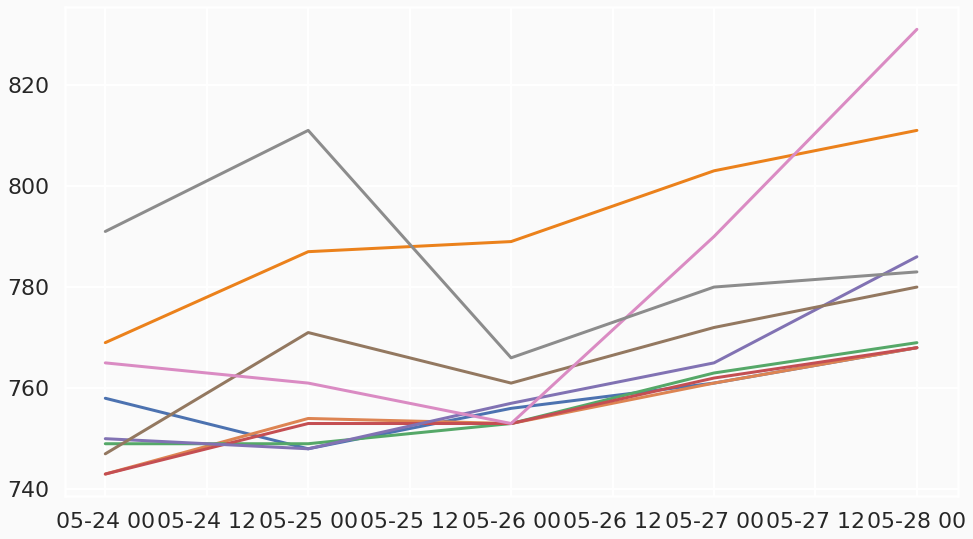

In [49]:
fig = plt.figure()
ax = plt.subplot(111)
fig.patch.set_facecolor("#FAFAFA")
ax.set_facecolor('#FAFAFA')
plt.plot(x, gt, color="#eb811b")
for pred in preds:
    plt.plot(x, pred, label=pred.index.get_level_values(3).unique())